# Predictiong biochemical activity against 2c9 with a small dataset

In this notebook we will try to use the more representative features of the Morgan fingerprint to fit a model with small dataset.


## Overview

- Load data
- Get fingerprint (in this case we simply load it from files)
- Select data with mutual information score
- DNN
    - Hyperparameters tunning

## 1) Packages

In [26]:
%matplotlib inline
%load_ext tensorboard
!rm -rf ./logs/ 

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize #, minmax_scale it could also be tried.
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from rdkit import Chem
from mordred import Calculator, descriptors

plt.style.use("ggplot")
matplotlib.rcParams.update({'font.size': 24})
PATH_DATA = "../datasets/CYP/"
print(tf.__version__)

load_clean_data =  True # Otherwise it will load data with NaN

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.0.0


## 2) Loading data

In [2]:
PATH_DATA = "../datasets/CYP/"

shared_data = pd.read_csv(os.path.join(PATH_DATA, "shared_set_cyp.csv"))
labels_2c9 = (shared_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
labels_3a4 = (shared_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)
testing_2c9_data = pd.read_csv(os.path.join(PATH_DATA, "only_2c9_set_cyp.csv"))
labels_testing_2c9 = (testing_2c9_data["p450-cyp2c9 Activity Outcome"] == "Active").values.astype(int)
testing_3a4_data = pd.read_csv(os.path.join(PATH_DATA, "only_3a4_set_cyp.csv"))
labels_testing_3a4 = (testing_3a4_data["p450-cyp3a4 Activity Outcome"] == "Active").values.astype(int)

In [3]:
def col_to_array(df, col_name='p450-cyp2c9 Activity Outcome'):
    col = df[col_name]
    arr = col.to_numpy() # class wants to make reference to active or inactive
    arr = np.reshape(arr, [arr.shape[0],1])
    return np.squeeze(arr)

In [4]:
smi_col_shared = col_to_array(shared_data, 'CanonicalSMILES')
smi_col_only2c9 = col_to_array(testing_2c9_data, 'CanonicalSMILES')

## 3) Get features (Morgan fingerprint)

We need to generate the features for the data sets, we will use MACCS fingerprints as implemented in RDKit.

In [5]:
def get_features(input_sdf):
    structures_shared = Chem.SDMolSupplier(input_sdf)
    features = []
    for mol in structures_shared:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp,arr)
        features.append(arr)
    return np.array(features)

In [6]:
if os.path.exists(os.path.join("features", "shared_set_features.npy")):
    features_shared = np.load(os.path.join("features", "shared_set_features.npy"))
else:
    features_shared = get_features(os.path.join(PATH_DATA, "shared_set_cyp.sdf"))
    np.save(os.path.join("features", "shared_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_2c9_set_features.npy")):
    features_only_2c9 = np.load(os.path.join("features", "only_2c9_set_features.npy"))
else:
    features_only_2c9 = get_features(os.path.join(PATH_DATA, "only_2c9_set.sdf"))
    np.save(os.path.join("features", "only_2c9_set_features.npy"), features_shared)
    
if os.path.exists(os.path.join("features", "only_3a4_set_features.npy")):
    features_only_3a4 = np.load(os.path.join("features", "only_3a4_set_features.npy"))
else:
    features_only_3a4 = get_features(os.path.join(PATH_DATA, "only_3a4_set.sdf.sdf"))
    np.save(os.path.join("features", "only_3a4_set_features.npy"), features_shared)

## 4) Feature selection

In this part we want to select the descriptors and the finferprint features that are very representative of the molecule activity.

In the following cell there are the percentage of values that are kept of the descriptors.
Since the fingerprint seems to have a low score in all its features (see plots below), a lower percentil was selected in order to avoid 'noise'.

In [7]:
# Percentage to be kept
percetile_fingerprint = 60 #40

In [8]:
def select_features_univar(X_train, Y_train, X_test, score_func=chi2, k_best=None, percentile = None):
    """score_func=chi2 (default), mutual_info_classif"""
    if not k_best == None:
        fs = SelectKBest(score_func=score_func, k=k_best)
    elif not percentile == None:
        fs = SelectPercentile(score_func=score_func, percentile=percentile)
    else:
        print("Introduce the number of best features to be kept (`k_best`) or the percentil.")
        return
    fs.fit(X_train, Y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def plot_score(fs, print_scores=False):
    """plot the score for all the features"""
    if print_scores:
        for i in range(len(fs.scores_)):
            print('Feature %d: %f' % (i, fs.scores_[i]))
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()

## 5) Fingerprint features selection

In this part we want to select the fingerprint features that are very representative of the molecule activity.
To do so, the the mutual information classification is used for the descriptor selection, for coherence with the descriptors.

However, in this case it is not mandatory to use the mutual information classification, therefore, we could also use the chi2 test.

Moreover, as the fingerprint are "boolean descriptors", we could also implement a variance threshold, as it has been previously done in other studies (Joan).

In [9]:
shared_features_fs, only2c9_features_fs, fs_rdkit = select_features_univar(features_shared, labels_2c9, features_only_2c9, score_func=mutual_info_classif, percentile = percetile_fingerprint)

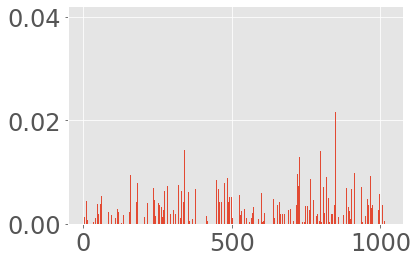

In [10]:
plot_score(fs_rdkit)

In [11]:
print(shared_features_fs.shape, only2c9_features_fs.shape)

(9420, 614) (2813, 614)


## 6) Preparing the trainig, validation and test sets

### 6.1) Splitting the data

We will split the data and reduce the training set to:

- 375 examples for the training set from the shared dataset (`shared_features_fs`)
- 125 examples for the validation set from the shared dataset (`shared_features_fs`)
- 125 examples for the test set from the only2c9 dataset (`only2c9_features_fs`)

In [12]:
def split_test_data(full_testset, labels_full_testset, testset_size, seed=1):
    np.random.seed(seed)
    m_testset = full_testset.shape[0] # number of examples in the full test set
    permutation_testset = list(np.random.permutation(m_testset))
    shuffled_test_data = full_testset[permutation_testset,:]
    shuffled_labels_test = labels_full_testset[permutation_testset]
    mini_test = shuffled_test_data[:testset_size,:]
    mini_labels_test = shuffled_labels_test[:testset_size].reshape(testset_size,1)
    return mini_test, mini_labels_test

In [16]:
dataset_size = 500                  # training + validation sets
trainset_size = int(0.75 * dataset_size)
testset_size = int(0.25 * dataset_size)  # To have the same #examples in the test and validation set (Assuming that the mini_dataset will be split 75% train/25%val.)

mini_testing_2c9_data, mini_labels_testing_2c9_data = split_test_data(only2c9_features_fs, labels_testing_2c9, testset_size)
print(mini_testing_2c9_data.shape, mini_labels_testing_2c9_data.shape)

(125, 614) (125, 1)


(375, 614) (125, 614) (375,) (125,)


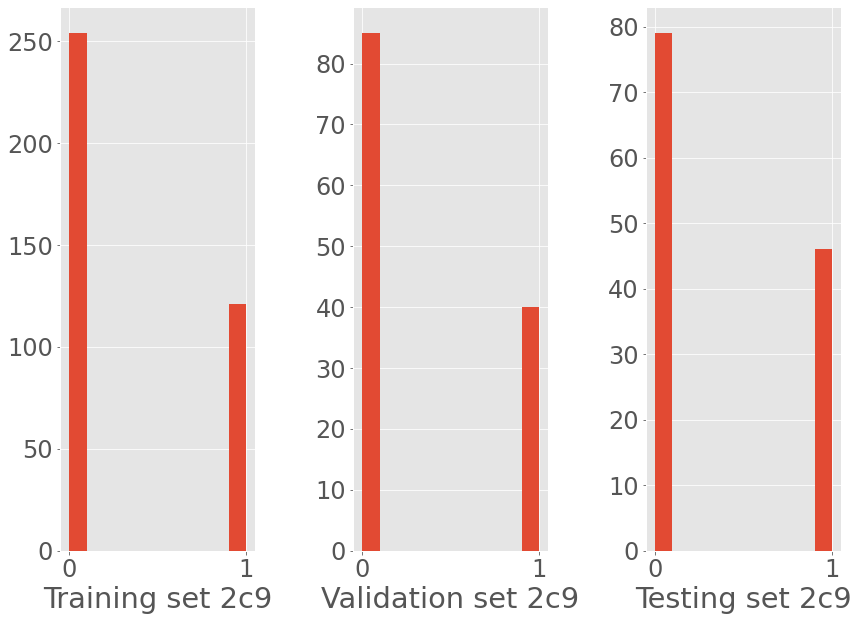

In [17]:
train_data, val_data, train_labels, val_labels = train_test_split(shared_features_fs, labels_2c9, train_size=trainset_size, test_size=testset_size, stratify=labels_2c9, random_state=2)


print(train_data.shape, val_data.shape, train_labels.shape, val_labels.shape)
fig, ax = plt.subplots(1, 3, figsize=(14,10))
ax[0].hist(train_labels)
ax[0].set_xlabel("Training set 2c9")
ax[1].hist(val_labels)
ax[1].set_xlabel("Validation set 2c9")
ax[2].hist(mini_labels_testing_2c9_data)
ax[2].set_xlabel("Testing set 2c9")
plt.subplots_adjust(wspace=0.5)

In [18]:
train_data = np.asarray(train_data).astype(np.float32)
val_data = np.asarray(val_data).astype(np.float32)
mini_testing_2c9_data = np.asarray(mini_testing_2c9_data).astype(np.float32)

Since we have an unbalanced dataset, we will attribute to each class a weight.
In this way we simulate having the same number of active and inactive cases.

In [19]:
class_weights = compute_class_weight('balanced',np.unique(train_labels), train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}

/Users/Anna/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0
 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1
 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1
 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1
 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0
 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [20]:
class_weight

{0: 0.7381889763779528, 1: 1.5495867768595042}

## 7) Neural network

In [31]:
def generate_model(layers_dim, lr, dropout, optimizer, L2):
    """layers_dim -- [n_input, n_hid_1, ..., n_output=1]"""
    hidden_layers = []
    for i in range(1,len(layers_dim)-1): hidden_layers.extend([tf.keras.layers.Dropout(dropout)] + [tf.keras.layers.Dense(layers_dim[i], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2))])
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(layers_dim[0], activation='relu', input_shape=(layers_dim[0],))] +
        hidden_layers + 
        [tf.keras.layers.Dense(layers_dim[-1], activation="sigmoid")])
    loss_function = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]) 
    return model

def plot_confusion(predicted_values, target_values):
    cm = confusion_matrix(target_values, predicted_values >= 0.5)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt="g", cmap="Greens")
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Inactive', 'Active']); ax.yaxis.set_ticklabels(['Inactive', 'Active'])
    plt.show()

def print_metrics(predicted_values, target_values, verbose=True):
    tn, fp, fn, tp = confusion_matrix(target_values, predicted_values >= 0.5).ravel()
    Sn = tp/(tp+fn)
    Sp = tn/(tn+fp)
    precision = tp/(tp+fp)
    ner = (Sn+Sp)/2
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    mcc = (tp*tn-fp*fn)/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    if verbose:
        print(f"NER: {ner:.3f}, Sensitivity or recall: {Sn:.3f}, Specificity: {Sp:.3f}, Precision: {precision:.3f}, Correctly calssified: {accuracy:.3f}, MCC: {mcc:.3f}")
    return {'accuracy': accuracy, 'precision': precision, 'recall': Sn, 'specificity':Sp, 'mcc':mcc, 'ner':ner}#[accuracy, mcc]#mcc


"""
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
          print("\n Reached 80% accuracy on training set so cancelling training!")
          self.model.stop_training = True
        if(logs.get('val_accuracy')>0.80):
          print("\n Reached 70% accuracy on validation set so cancelling training!")
          self.model.stop_training = True
"""      

'\nclass myCallback(tf.keras.callbacks.Callback):\n    def on_epoch_end(self, epoch, logs={}):\n        if(logs.get(\'accuracy\')>0.80):\n          print("\n Reached 80% accuracy on training set so cancelling training!")\n          self.model.stop_training = True\n        if(logs.get(\'val_accuracy\')>0.80):\n          print("\n Reached 70% accuracy on validation set so cancelling training!")\n          self.model.stop_training = True\n'

In [23]:
from io import BytesIO

logdir="logs/fit/morgan_feature_selection/"
classes=['Inactive', 'Active']

file_writer = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    val_pred = model_small_dataset.predict_classes(val_data)
 
    con_mat = tf.math.confusion_matrix(labels=val_labels, predictions=val_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
 
    con_mat_df = pd.DataFrame(con_mat_norm,
                             index = classes, 
                             columns = classes)
 
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
    buf = BytesIO()
    plt.savefig(buf, format='png')
 
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
 
    image = tf.expand_dims(image, 0)
  
    # Log the confusion matrix as an image summary.
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)
  
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
 
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [96]:
import datetime

layers_dim = [train_data.shape[1], 130,130,130,130,130,130, 1]
lr = 0.001
dropout = 0.2
optimizer = 'adam'
L2 = 0.001

#callbacks = myCallback()

os.makedirs("logs/fit/morgan_feature_selection", exist_ok=True)
log_dir = "logs/fit/morgan_feature_selection/" + f'nl_{layers_dim}_lr_{lr}_drop_{dropout}_opt_{optimizer}_L2_{L2}' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
hist_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_small_dataset =generate_model(layers_dim, lr, dropout, optimizer, L2)
#model_small_dataset.summary()


history = model_small_dataset.fit(
      train_data, train_labels,
      epochs=10,
      verbose=2,
      #validation_data = (mini_testing_2c9_data, mini_labels_testing_2c9_data)
      validation_data = (val_data, val_labels),
      callbacks=[hist_callback, cm_callback],
      class_weight=class_weight
      )

Train on 375 samples, validate on 125 samples
Epoch 1/10
375/375 - 22s - loss: 10.2858 - accuracy: 0.3360 - precision_15: 0.3242 - recall_15: 0.9752 - val_loss: 10.2595 - val_accuracy: 0.3200 - val_precision_15: 0.3200 - val_recall_15: 1.0000
Epoch 2/10
375/375 - 1s - loss: 10.2411 - accuracy: 0.3387 - precision_15: 0.3251 - recall_15: 0.9752 - val_loss: 10.2136 - val_accuracy: 0.3200 - val_precision_15: 0.3200 - val_recall_15: 1.0000
Epoch 3/10
375/375 - 1s - loss: 10.1940 - accuracy: 0.3413 - precision_15: 0.3230 - recall_15: 0.9504 - val_loss: 10.1681 - val_accuracy: 0.3360 - val_precision_15: 0.3252 - val_recall_15: 1.0000
Epoch 4/10
375/375 - 1s - loss: 10.1486 - accuracy: 0.3520 - precision_15: 0.3287 - recall_15: 0.9669 - val_loss: 10.1227 - val_accuracy: 0.3360 - val_precision_15: 0.3223 - val_recall_15: 0.9750
Epoch 5/10
375/375 - 1s - loss: 10.1024 - accuracy: 0.3653 - precision_15: 0.3274 - recall_15: 0.9174 - val_loss: 10.0775 - val_accuracy: 0.3520 - val_precision_15: 0.31

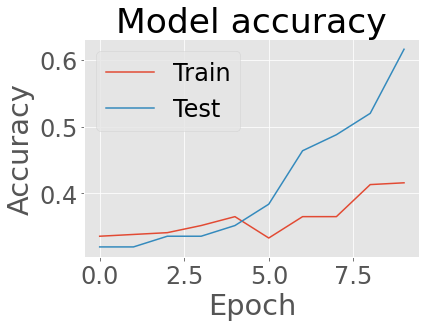

In [97]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

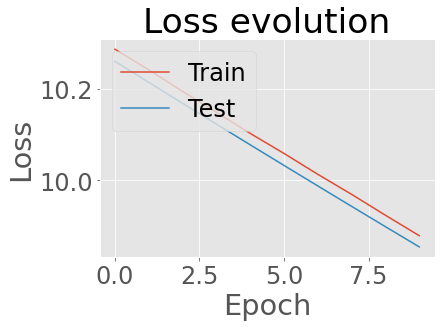

In [98]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

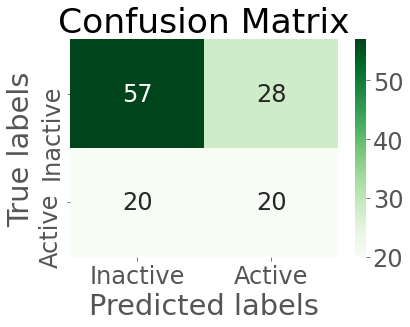

In [99]:
results = model_small_dataset.evaluate(val_data, val_labels)
predictions = model_small_dataset.predict(val_data)
print_metrics(predictions, val_labels)
plot_confusion(predictions, val_labels)

125/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

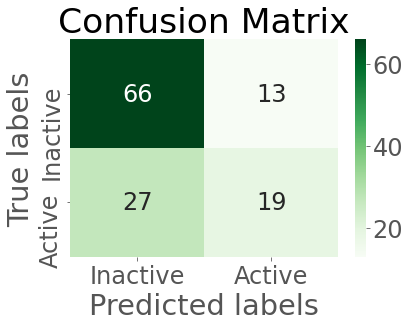

In [100]:
results = model_small_dataset.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data)
predictions = model_small_dataset.predict(mini_testing_2c9_data)
print_metrics(predictions, mini_labels_testing_2c9_data)
plot_confusion(predictions, mini_labels_testing_2c9_data)

In [89]:
%tensorboard --logdir logs/fit/morgan_feature_selection

### 7.2.) Cross Validation

Based on [Manual k-Fold Cross Validation](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/).

This methodology provides a robust estimation of the performance of a model on unseen data. It does this by splitting the training dataset into k subsets and takes turns training models on all subsets except one which is held out, and evaluating model performance on the held out validation dataset.

In the example below we use the handy StratifiedKFold class from the scikit-learn Python machine learning library to split up the training dataset into 10 folds. The folds are stratified, meaning that the algorithm attempts to balance the number of instances of each class in each fold.


**Update**

With the new version, `plot_results_CV()` can print boxplot even if there is some nan value in the list.

In [22]:
def run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, test_data, test_labels, folds=10, seed=1):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    MCCs_train, MCCs_val, MCCs_test = [],[],[]
    accs_train, accs_val, accs_test = [],[],[]
    recall_train, recall_val, recall_test = [],[],[]
    precision_train, precision_val, precision_test = [],[],[]
    actives_train, actives_val, actives_test = [],[],[]
    best_model = None
    best_model_MCC = -2
    best_model_ind = 0
    testset_size = int(train_val_data.shape[0]/folds)
    
    if not testset_size == test_data.shape[0]:
        test_data, test_labels = split_test_data(test_data, test_labels, testset_size, seed=seed)
    
    for i, (train_index, val_index) in enumerate(skf.split(train_val_data, train_val_labels)):
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        actives_train.append(sum(train_labels))
        actives_val.append(sum(val_labels))
        actives_test.append(sum(test_labels))
        print(f"Calculating with fold {i}")
        
        model = generate_model(layers_dim, lr, dropout, optimizer, L2)
        history = model.fit(train_data, train_labels, epochs=10, verbose=2, validation_data = (val_data, val_labels), class_weight=class_weight)
      
        pred_train = model.predict(train_data)
        dict_train = print_metrics(pred_train, train_labels)
        train_acc, train_mcc, train_recall, train_precision = dict_train['accuracy'], dict_train['mcc'],  dict_train['recall'],  dict_train['precision']

        pred_val = model.predict(val_data)
        print(f"---> Validation set fold {i}")
        dict_val = print_metrics(pred_val, val_labels)
        val_acc, val_mcc, val_recall, val_precision = dict_val['accuracy'], dict_val['mcc'],  dict_val['recall'],  dict_val['precision']
        plot_confusion(pred_val, val_labels)
        
        predictions = model.predict(test_data)
        print(f"---> Test set fold {i}")
        dict_test = print_metrics(predictions, test_labels)
        test_acc, test_mcc, test_recall, test_precision = dict_test['accuracy'], dict_test['mcc'],  dict_test['recall'],  dict_test['precision']
        plot_confusion(predictions, test_labels)
        
        if test_mcc > best_model_MCC:
            best_model = model
            best_model_MCC = test_mcc
            best_model_ind = i
        MCCs_train.append(train_mcc)
        MCCs_val.append(val_mcc)
        MCCs_test.append(test_mcc)
        accs_train.append(train_acc)
        accs_val.append(val_acc)
        accs_test.append(test_acc)
        recall_train.append(train_recall)
        recall_val.append(val_recall)
        recall_test.append(test_recall)
        precision_train.append(train_precision)
        precision_val.append(val_precision)
        precision_test.append(test_precision)
    print(f"Best model was obtained from fold {best_model_ind} with MCC {best_model_MCC}")
    for i, (train_index, test_index) in enumerate(skf.split(train_val_data, train_val_labels)):
        print(f"Calculating with fold {i}")
        train_data, val_data = train_val_data[train_index], train_val_data[val_index]
        train_labels, val_labels = train_val_labels[train_index], train_val_labels[val_index]
        
        pred_val = best_model.predict(val_data)
        print(f"---> Validation set fold {i}")
        print_metrics(pred_val, val_labels)
        plot_confusion(pred_val, val_labels)
        
        predictions = best_model.predict(test_data)
        print(f"---> Test set fold {i}")
        print_metrics(predictions, test_labels)
        plot_confusion(predictions, test_labels)
    return (MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, recall_train, recall_val, recall_test, precision_train, precision_val, precision_test), best_model

def plot_results_CV(MCCs_train, MCCs_val, MCCs_test, accs_train, accs_val, accs_test, actives_train, actives_val, actives_test, recall_train, recall_val, recall_test, precision_train, precision_val, precision_test):
    fig, ax = plt.subplots(2,3, figsize=(16,16))
    y_min = -0.1+np.nanmin([np.nanmin(accs_train), np.nanmin(accs_val),np.nanmin(accs_test), np.nanmin(MCCs_train), np.nanmin(MCCs_val), np.nanmin(MCCs_test), np.nanmin(recall_train), np.nanmin(recall_val), np.nanmin(recall_test), np.nanmin(precision_train), np.nanmin(precision_val), np.nanmin(precision_test)])
    y_max = 0.1+np.nanmax([np.nanmax(accs_train), np.nanmax(accs_val), np.nanmax(accs_test), np.nanmax(MCCs_train), np.nanmax(MCCs_val), np.nanmax(MCCs_test), np.nanmax(recall_train), np.nanmax(recall_val), np.nanmax(recall_test), np.nanmax(precision_train), np.nanmax(precision_val), np.nanmax(precision_test)])
    ax[0, 0].boxplot([np.array(accs_train)[~np.isnan(accs_train)], np.array(accs_val)[~np.isnan(accs_val)], np.array(accs_test)[~np.isnan(accs_test)]], labels=["Train", "Val" , "Test"])
    ax[0, 1].boxplot([np.array(MCCs_train)[~np.isnan(MCCs_train)], np.array(MCCs_val)[~np.isnan(MCCs_val)], np.array(MCCs_test)[~np.isnan(MCCs_test)]], labels=["Train", "Val", "Test"])
    ax[0, 2].boxplot([np.array(actives_train)[~np.isnan(actives_train)], np.array(actives_val)[~np.isnan(actives_val)], np.array(actives_test)[~np.isnan(actives_test)]], labels=["Train", "Val", "Test"])
    ax[1, 0].boxplot([np.array(recall_train)[~np.isnan(recall_train)], np.array(recall_val)[~np.isnan(recall_val)], np.array(recall_test)[~np.isnan(recall_test)]], labels=["Train", "Val" , "Test"])
    ax[1, 1].boxplot([np.array(precision_train)[~np.isnan(precision_train)], np.array(precision_val)[~np.isnan(precision_val)], np.array(precision_test)[~np.isnan(precision_test)]], labels=["Train", "Val", "Test"]) 
    ax[0, 0].set_ylim(top=y_max, bottom=y_min)
    ax[0, 1].set_ylim(top=y_max, bottom=y_min)
    ax[1, 0].set_ylim(top=y_max, bottom=y_min)
    ax[1, 1].set_ylim(top=y_max, bottom=y_min)
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 1].set_ylabel("MCC")
    ax[0, 2].set_ylabel("Actives proportion")
    ax[1, 0].set_ylabel("Recall")
    ax[1, 1].set_ylabel("Precision")
    plt.tight_layout()
    plt.show()

In [23]:
train_val_data = np.concatenate((train_data, val_data), axis=0)
train_val_labels = np.concatenate((train_labels, val_labels), axis=0)

print(train_val_data.shape, train_val_labels.shape)

(500, 614) (500,)


Calculating with fold 0
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 11s - loss: 1.4962 - accuracy: 0.5244 - precision_11: 0.3135 - recall_11: 0.4000 - val_loss: 1.4200 - val_accuracy: 0.3200 - val_precision_11: 0.3200 - val_recall_11: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3733 - accuracy: 0.3444 - precision_11: 0.3280 - recall_11: 0.9862 - val_loss: 1.3046 - val_accuracy: 0.3200 - val_precision_11: 0.3200 - val_recall_11: 1.0000
Epoch 3/10
450/450 - 1s - loss: 1.2611 - accuracy: 0.5844 - precision_11: 0.4037 - recall_11: 0.6069 - val_loss: 1.1880 - val_accuracy: 0.5200 - val_precision_11: 0.4000 - val_recall_11: 1.0000
Epoch 4/10
450/450 - 1s - loss: 1.0725 - accuracy: 0.6889 - precision_11: 0.5105 - recall_11: 0.8414 - val_loss: 1.0601 - val_accuracy: 0.7800 - val_precision_11: 0.7273 - val_recall_11: 0.5000
Epoch 5/10
450/450 - 1s - loss: 0.8124 - accuracy: 0.8511 - precision_11: 0.7500 - recall_11: 0.8069 - val_loss: 1.1004 - val_accuracy: 0.7400 - val_preci

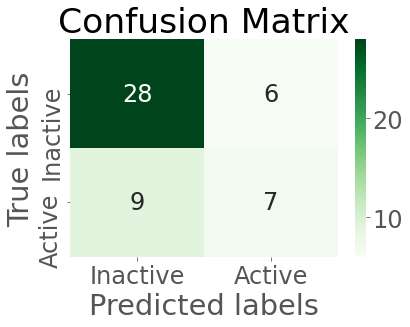

---> Test set fold 0
NER: 0.641, Sensitivity or recall: 0.524, Specificity: 0.759, Precision: 0.611, Correctly calssified: 0.660, MCC: 0.290


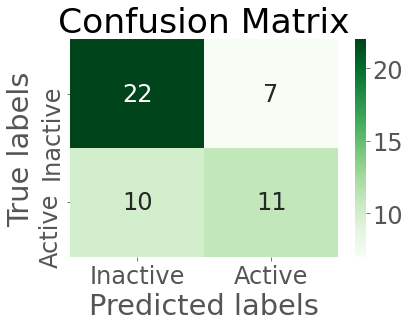

Calculating with fold 1
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 9s - loss: 1.4985 - accuracy: 0.6333 - precision_12: 0.3438 - recall_12: 0.1517 - val_loss: 1.4307 - val_accuracy: 0.3200 - val_precision_12: 0.3200 - val_recall_12: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3843 - accuracy: 0.3222 - precision_12: 0.3222 - recall_12: 1.0000 - val_loss: 1.3241 - val_accuracy: 0.3200 - val_precision_12: 0.3200 - val_recall_12: 1.0000
Epoch 3/10
450/450 - 1s - loss: 1.2586 - accuracy: 0.3356 - precision_12: 0.3266 - recall_12: 1.0000 - val_loss: 1.2177 - val_accuracy: 0.6800 - val_precision_12: 0.5000 - val_recall_12: 0.8125
Epoch 4/10
450/450 - 1s - loss: 1.0792 - accuracy: 0.7578 - precision_12: 0.5789 - recall_12: 0.9103 - val_loss: 1.1298 - val_accuracy: 0.7400 - val_precision_12: 0.6364 - val_recall_12: 0.4375
Epoch 5/10
450/450 - 1s - loss: 0.7882 - accuracy: 0.9000 - precision_12: 0.8125 - recall_12: 0.8966 - val_loss: 1.4951 - val_accuracy: 0.7400 - val_precis

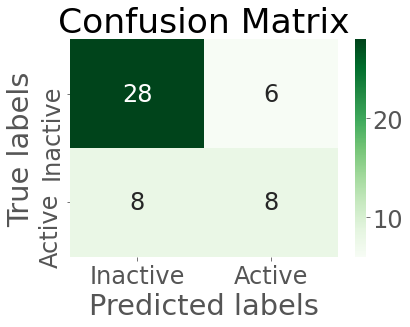

---> Test set fold 1
NER: 0.607, Sensitivity or recall: 0.524, Specificity: 0.690, Precision: 0.550, Correctly calssified: 0.620, MCC: 0.215


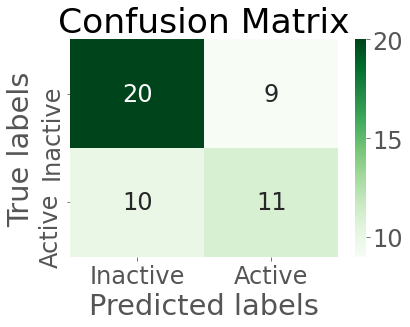

Calculating with fold 2
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 9s - loss: 1.4999 - accuracy: 0.4556 - precision_13: 0.3252 - recall_13: 0.6414 - val_loss: 1.4259 - val_accuracy: 0.3200 - val_precision_13: 0.3200 - val_recall_13: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3601 - accuracy: 0.3622 - precision_13: 0.3318 - recall_13: 0.9655 - val_loss: 1.2919 - val_accuracy: 0.5800 - val_precision_13: 0.4286 - val_recall_13: 0.9375
Epoch 3/10
450/450 - 1s - loss: 1.1599 - accuracy: 0.6978 - precision_13: 0.5176 - recall_13: 0.9103 - val_loss: 1.1800 - val_accuracy: 0.7000 - val_precision_13: 0.5263 - val_recall_13: 0.6250
Epoch 4/10
450/450 - 1s - loss: 0.8632 - accuracy: 0.8867 - precision_13: 0.8176 - recall_13: 0.8345 - val_loss: 1.2616 - val_accuracy: 0.7400 - val_precision_13: 0.5882 - val_recall_13: 0.6250
Epoch 5/10
450/450 - 1s - loss: 0.6795 - accuracy: 0.9511 - precision_13: 0.9073 - recall_13: 0.9448 - val_loss: 1.1753 - val_accuracy: 0.7400 - val_precis

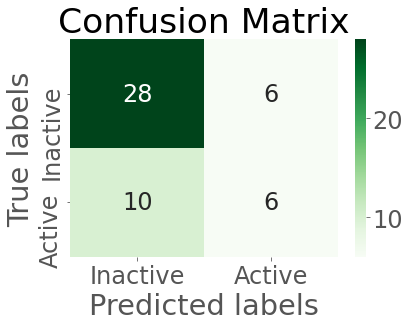

---> Test set fold 2
NER: 0.648, Sensitivity or recall: 0.571, Specificity: 0.724, Precision: 0.600, Correctly calssified: 0.660, MCC: 0.298


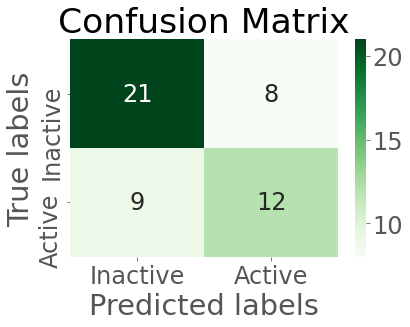

Calculating with fold 3
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 11s - loss: 1.5060 - accuracy: 0.3889 - precision_14: 0.3054 - recall_14: 0.7034 - val_loss: 1.4312 - val_accuracy: 0.3400 - val_precision_14: 0.3111 - val_recall_14: 0.8750
Epoch 2/10
450/450 - 1s - loss: 1.3806 - accuracy: 0.4044 - precision_14: 0.3315 - recall_14: 0.8345 - val_loss: 1.3255 - val_accuracy: 0.3600 - val_precision_14: 0.3261 - val_recall_14: 0.9375
Epoch 3/10
450/450 - 1s - loss: 1.2121 - accuracy: 0.6156 - precision_14: 0.4507 - recall_14: 0.8828 - val_loss: 1.2152 - val_accuracy: 0.7000 - val_precision_14: 0.5294 - val_recall_14: 0.5625
Epoch 4/10
450/450 - 1s - loss: 0.9453 - accuracy: 0.8400 - precision_14: 0.7296 - recall_14: 0.8000 - val_loss: 1.6926 - val_accuracy: 0.4400 - val_precision_14: 0.3235 - val_recall_14: 0.6875
Epoch 5/10
450/450 - 1s - loss: 0.7463 - accuracy: 0.8911 - precision_14: 0.7667 - recall_14: 0.9517 - val_loss: 1.6447 - val_accuracy: 0.6800 - val_preci

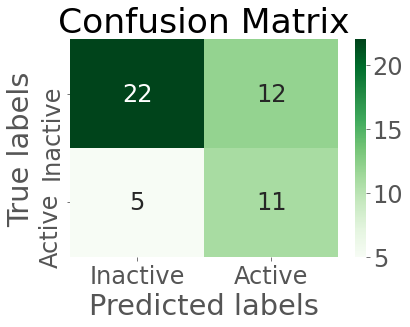

---> Test set fold 3
NER: 0.576, Sensitivity or recall: 0.429, Specificity: 0.724, Precision: 0.529, Correctly calssified: 0.600, MCC: 0.159


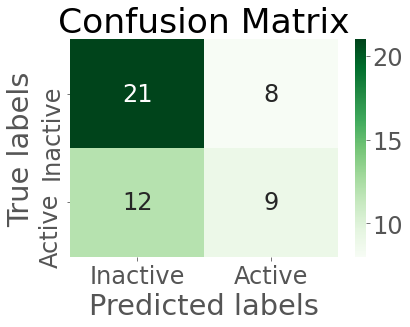

Calculating with fold 4
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 11s - loss: 1.4976 - accuracy: 0.6111 - precision_15: 0.3529 - recall_15: 0.2483 - val_loss: 1.4157 - val_accuracy: 0.3200 - val_precision_15: 0.3200 - val_recall_15: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3654 - accuracy: 0.3533 - precision_15: 0.3193 - recall_15: 0.8897 - val_loss: 1.2824 - val_accuracy: 0.3800 - val_precision_15: 0.3404 - val_recall_15: 1.0000
Epoch 3/10
450/450 - 1s - loss: 1.1951 - accuracy: 0.6711 - precision_15: 0.4936 - recall_15: 0.8000 - val_loss: 1.1254 - val_accuracy: 0.6400 - val_precision_15: 0.4545 - val_recall_15: 0.6250
Epoch 4/10
450/450 - 1s - loss: 0.9777 - accuracy: 0.8222 - precision_15: 0.6923 - recall_15: 0.8069 - val_loss: 1.0892 - val_accuracy: 0.7200 - val_precision_15: 0.5625 - val_recall_15: 0.5625
Epoch 5/10
450/450 - 1s - loss: 0.7120 - accuracy: 0.9311 - precision_15: 0.8519 - recall_15: 0.9517 - val_loss: 1.2153 - val_accuracy: 0.7600 - val_preci

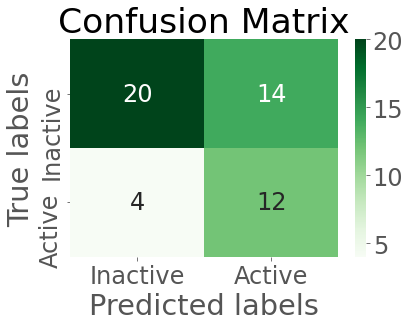

---> Test set fold 4
NER: 0.631, Sensitivity or recall: 0.571, Specificity: 0.690, Precision: 0.571, Correctly calssified: 0.640, MCC: 0.261


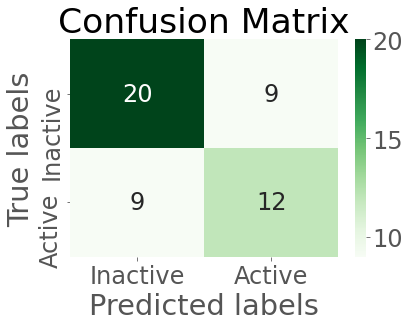

Calculating with fold 5
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 9s - loss: 1.4955 - accuracy: 0.6156 - precision_16: 0.3293 - recall_16: 0.1862 - val_loss: 1.4217 - val_accuracy: 0.3200 - val_precision_16: 0.3200 - val_recall_16: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3685 - accuracy: 0.3756 - precision_16: 0.3365 - recall_16: 0.9655 - val_loss: 1.3133 - val_accuracy: 0.4000 - val_precision_16: 0.3409 - val_recall_16: 0.9375
Epoch 3/10
450/450 - 1s - loss: 1.2048 - accuracy: 0.5156 - precision_16: 0.3904 - recall_16: 0.8966 - val_loss: 1.2751 - val_accuracy: 0.6600 - val_precision_16: 0.4444 - val_recall_16: 0.2500
Epoch 4/10
450/450 - 1s - loss: 0.9466 - accuracy: 0.8444 - precision_16: 0.7301 - recall_16: 0.8207 - val_loss: 1.5468 - val_accuracy: 0.6600 - val_precision_16: 0.4444 - val_recall_16: 0.2500
Epoch 5/10
450/450 - 1s - loss: 0.7245 - accuracy: 0.9244 - precision_16: 0.8776 - recall_16: 0.8897 - val_loss: 1.8444 - val_accuracy: 0.6800 - val_precis

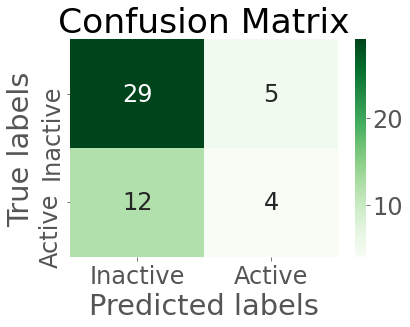

---> Test set fold 5
NER: 0.600, Sensitivity or recall: 0.476, Specificity: 0.724, Precision: 0.556, Correctly calssified: 0.620, MCC: 0.206


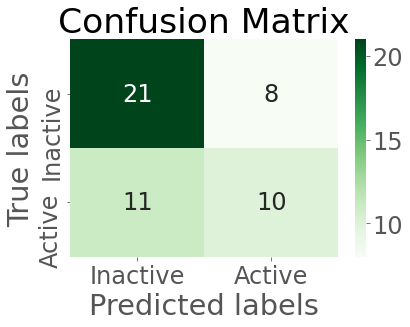

Calculating with fold 6
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 9s - loss: 1.4892 - accuracy: 0.5378 - precision_17: 0.3179 - recall_17: 0.3793 - val_loss: 1.4038 - val_accuracy: 0.3600 - val_precision_17: 0.3333 - val_recall_17: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3555 - accuracy: 0.3778 - precision_17: 0.3342 - recall_17: 0.9379 - val_loss: 1.2759 - val_accuracy: 0.3400 - val_precision_17: 0.3265 - val_recall_17: 1.0000
Epoch 3/10
450/450 - 1s - loss: 1.2160 - accuracy: 0.4422 - precision_17: 0.3620 - recall_17: 0.9586 - val_loss: 1.1512 - val_accuracy: 0.7000 - val_precision_17: 0.5333 - val_recall_17: 0.5000
Epoch 4/10
450/450 - 1s - loss: 1.0087 - accuracy: 0.7956 - precision_17: 0.6402 - recall_17: 0.8345 - val_loss: 1.1181 - val_accuracy: 0.6400 - val_precision_17: 0.4375 - val_recall_17: 0.4375
Epoch 5/10
450/450 - 1s - loss: 0.7291 - accuracy: 0.9067 - precision_17: 0.8323 - recall_17: 0.8897 - val_loss: 1.4682 - val_accuracy: 0.6400 - val_precis

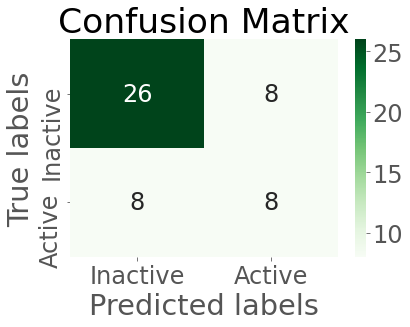

---> Test set fold 6
NER: 0.566, Sensitivity or recall: 0.476, Specificity: 0.655, Precision: 0.500, Correctly calssified: 0.580, MCC: 0.132


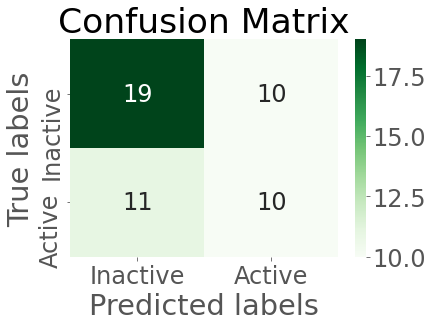

Calculating with fold 7
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 8s - loss: 1.4986 - accuracy: 0.4089 - precision_18: 0.3246 - recall_18: 0.7724 - val_loss: 1.4247 - val_accuracy: 0.3200 - val_precision_18: 0.3200 - val_recall_18: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3643 - accuracy: 0.3689 - precision_18: 0.3372 - recall_18: 0.9931 - val_loss: 1.2950 - val_accuracy: 0.6000 - val_precision_18: 0.4167 - val_recall_18: 0.6250
Epoch 3/10
450/450 - 1s - loss: 1.2196 - accuracy: 0.6778 - precision_18: 0.5000 - recall_18: 0.7034 - val_loss: 1.1465 - val_accuracy: 0.6600 - val_precision_18: 0.4783 - val_recall_18: 0.6875
Epoch 4/10
450/450 - 1s - loss: 0.9386 - accuracy: 0.8644 - precision_18: 0.7593 - recall_18: 0.8483 - val_loss: 1.4655 - val_accuracy: 0.6400 - val_precision_18: 0.4615 - val_recall_18: 0.7500
Epoch 5/10
450/450 - 1s - loss: 0.7134 - accuracy: 0.9111 - precision_18: 0.8302 - recall_18: 0.9103 - val_loss: 1.4389 - val_accuracy: 0.5800 - val_precis

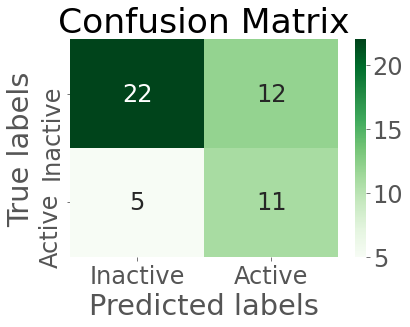

---> Test set fold 7
NER: 0.566, Sensitivity or recall: 0.476, Specificity: 0.655, Precision: 0.500, Correctly calssified: 0.580, MCC: 0.132


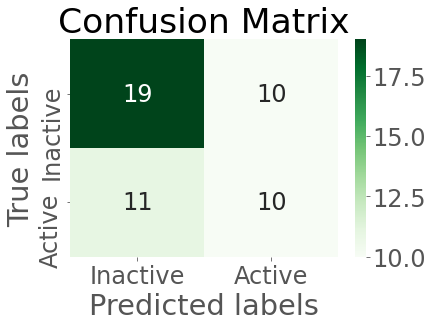

Calculating with fold 8
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 12s - loss: 1.4969 - accuracy: 0.6578 - precision_19: 0.3333 - recall_19: 0.0621 - val_loss: 1.4125 - val_accuracy: 0.7400 - val_precision_19: 0.6154 - val_recall_19: 0.5000
Epoch 2/10
450/450 - 1s - loss: 1.3612 - accuracy: 0.5556 - precision_19: 0.3904 - recall_19: 0.6759 - val_loss: 1.2972 - val_accuracy: 0.7400 - val_precision_19: 1.0000 - val_recall_19: 0.1875
Epoch 3/10
450/450 - 1s - loss: 1.2190 - accuracy: 0.7156 - precision_19: 0.5680 - recall_19: 0.4897 - val_loss: 1.2159 - val_accuracy: 0.4200 - val_precision_19: 0.3556 - val_recall_19: 1.0000
Epoch 4/10
450/450 - 1s - loss: 1.0391 - accuracy: 0.7000 - precision_19: 0.5216 - recall_19: 0.8345 - val_loss: 1.1791 - val_accuracy: 0.7400 - val_precision_19: 0.6364 - val_recall_19: 0.4375
Epoch 5/10
450/450 - 1s - loss: 0.7704 - accuracy: 0.8800 - precision_19: 0.7862 - recall_19: 0.8621 - val_loss: 1.4293 - val_accuracy: 0.7600 - val_preci

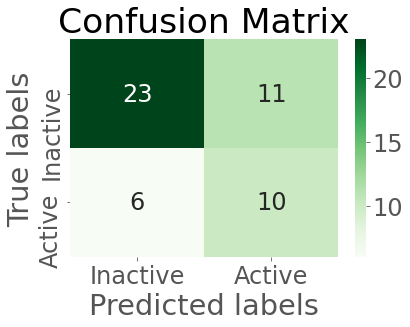

---> Test set fold 8
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


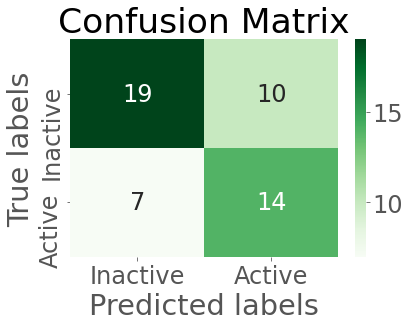

Calculating with fold 9
Train on 450 samples, validate on 50 samples
Epoch 1/10
450/450 - 9s - loss: 1.4786 - accuracy: 0.3800 - precision_20: 0.3265 - recall_20: 0.8819 - val_loss: 1.3989 - val_accuracy: 0.4200 - val_precision_20: 0.3696 - val_recall_20: 1.0000
Epoch 2/10
450/450 - 1s - loss: 1.3332 - accuracy: 0.3333 - precision_20: 0.3243 - recall_20: 1.0000 - val_loss: 1.2544 - val_accuracy: 0.3600 - val_precision_20: 0.3469 - val_recall_20: 1.0000
Epoch 3/10
450/450 - 1s - loss: 1.1733 - accuracy: 0.3689 - precision_20: 0.3349 - recall_20: 0.9861 - val_loss: 1.1871 - val_accuracy: 0.5000 - val_precision_20: 0.4000 - val_recall_20: 0.9412
Epoch 4/10
450/450 - 1s - loss: 0.9541 - accuracy: 0.7644 - precision_20: 0.5856 - recall_20: 0.9028 - val_loss: 1.1654 - val_accuracy: 0.7000 - val_precision_20: 0.5833 - val_recall_20: 0.4118
Epoch 5/10
450/450 - 1s - loss: 0.7471 - accuracy: 0.8911 - precision_20: 0.8065 - recall_20: 0.8681 - val_loss: 1.7012 - val_accuracy: 0.6000 - val_precis

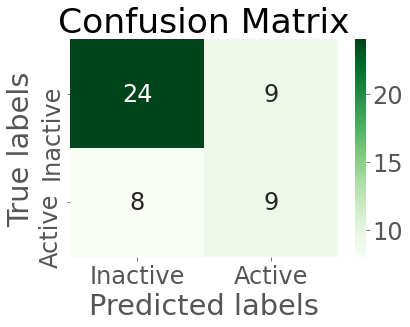

---> Test set fold 9
NER: 0.641, Sensitivity or recall: 0.524, Specificity: 0.759, Precision: 0.611, Correctly calssified: 0.660, MCC: 0.290


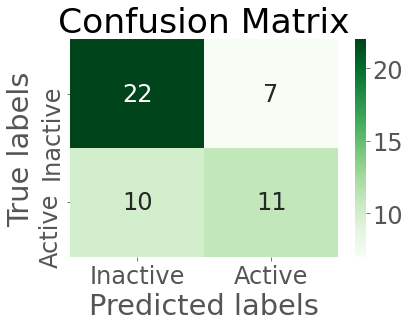

Best model was obtained from fold 8 with MCC 0.3179472918595553
Calculating with fold 0
---> Validation set fold 0
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


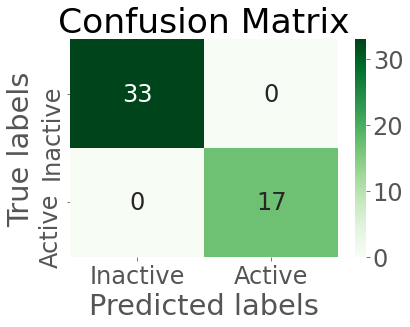

---> Test set fold 0
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


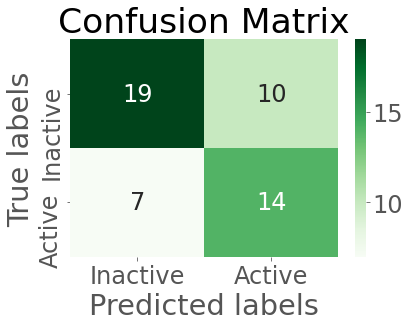

Calculating with fold 1
---> Validation set fold 1
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


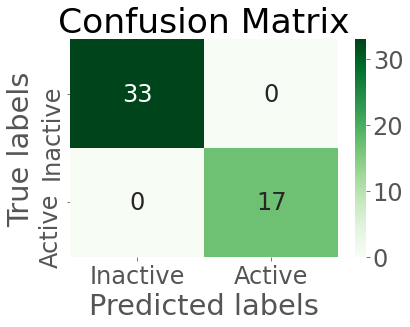

---> Test set fold 1
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


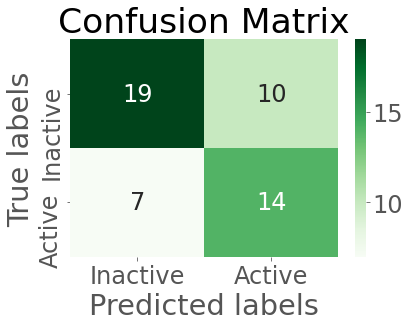

Calculating with fold 2
---> Validation set fold 2
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


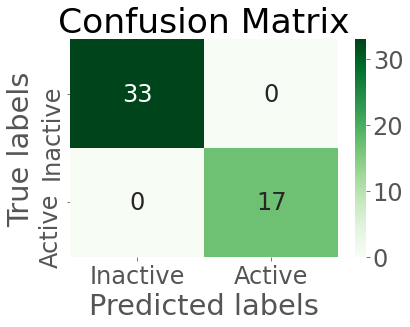

---> Test set fold 2
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


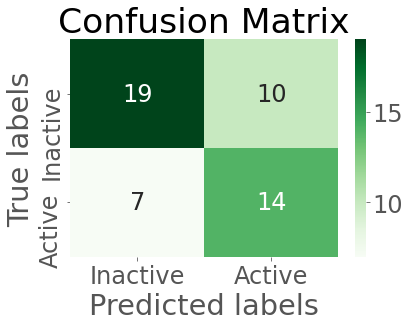

Calculating with fold 3
---> Validation set fold 3
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


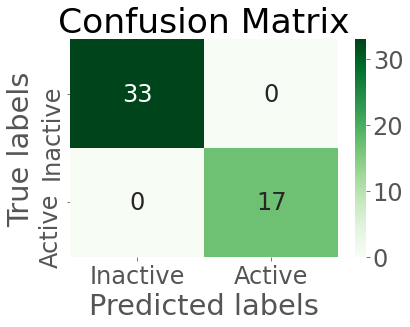

---> Test set fold 3
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


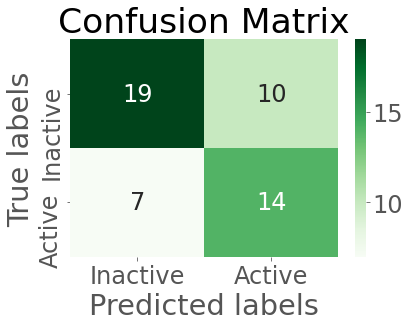

Calculating with fold 4
---> Validation set fold 4
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


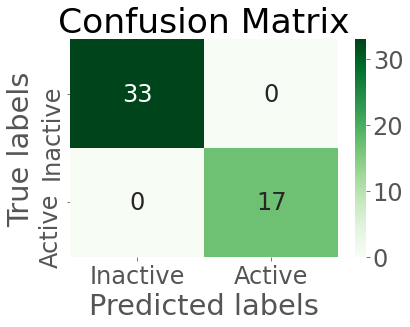

---> Test set fold 4
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


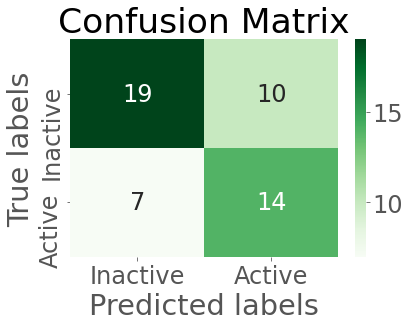

Calculating with fold 5
---> Validation set fold 5
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


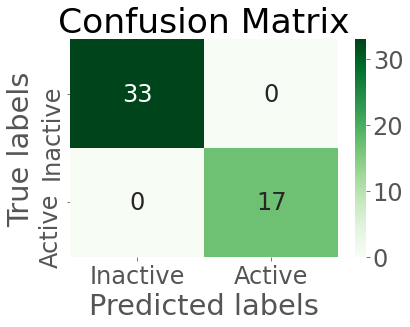

---> Test set fold 5
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


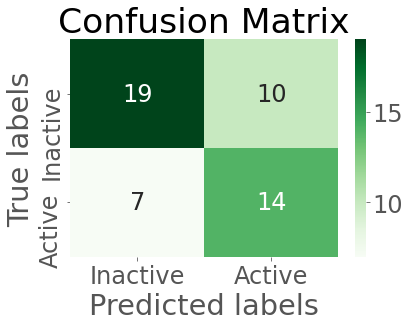

Calculating with fold 6
---> Validation set fold 6
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


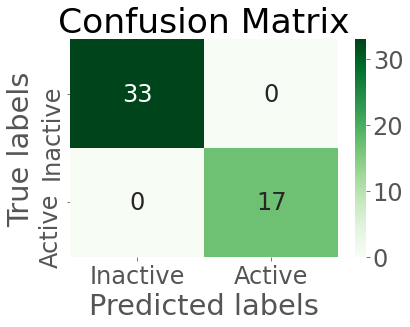

---> Test set fold 6
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


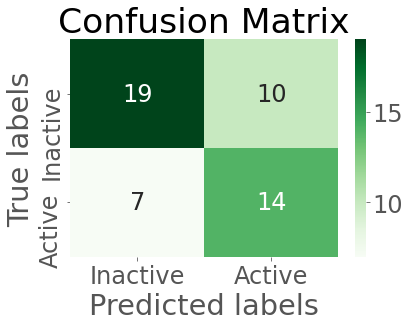

Calculating with fold 7
---> Validation set fold 7
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


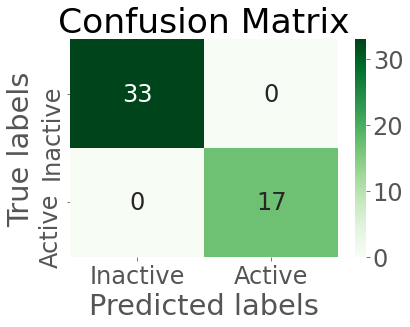

---> Test set fold 7
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


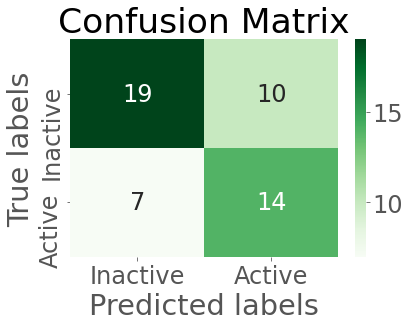

Calculating with fold 8
---> Validation set fold 8
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


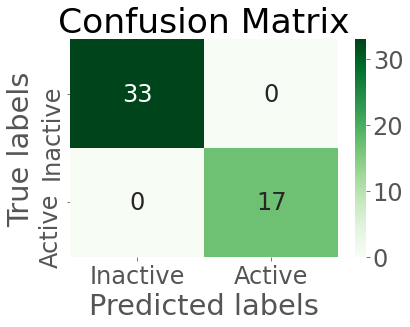

---> Test set fold 8
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


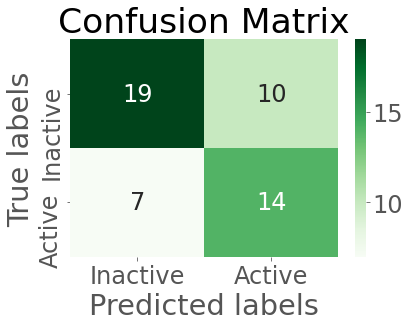

Calculating with fold 9
---> Validation set fold 9
NER: 1.000, Sensitivity or recall: 1.000, Specificity: 1.000, Precision: 1.000, Correctly calssified: 1.000, MCC: 1.000


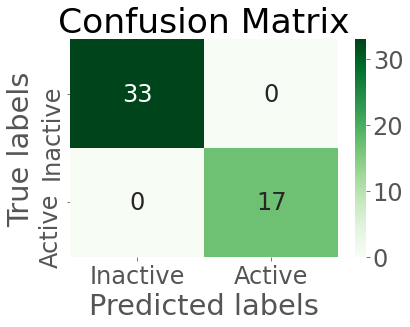

---> Test set fold 9
NER: 0.661, Sensitivity or recall: 0.667, Specificity: 0.655, Precision: 0.583, Correctly calssified: 0.660, MCC: 0.318


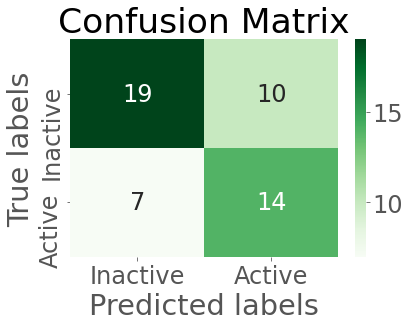

In [32]:
layers_dim = [train_data.shape[1], 130,130,130,130,130,130, 1]
lr = 0.001
dropout = 0.2
optimizer = 'adam'
L2 = 0.001
np.random.seed(1)

CV_parameters, best_model = run_cross_validation(layers_dim, lr, dropout, optimizer, L2, train_val_data, train_val_labels, mini_testing_2c9_data, mini_labels_testing_2c9_data, folds=10)

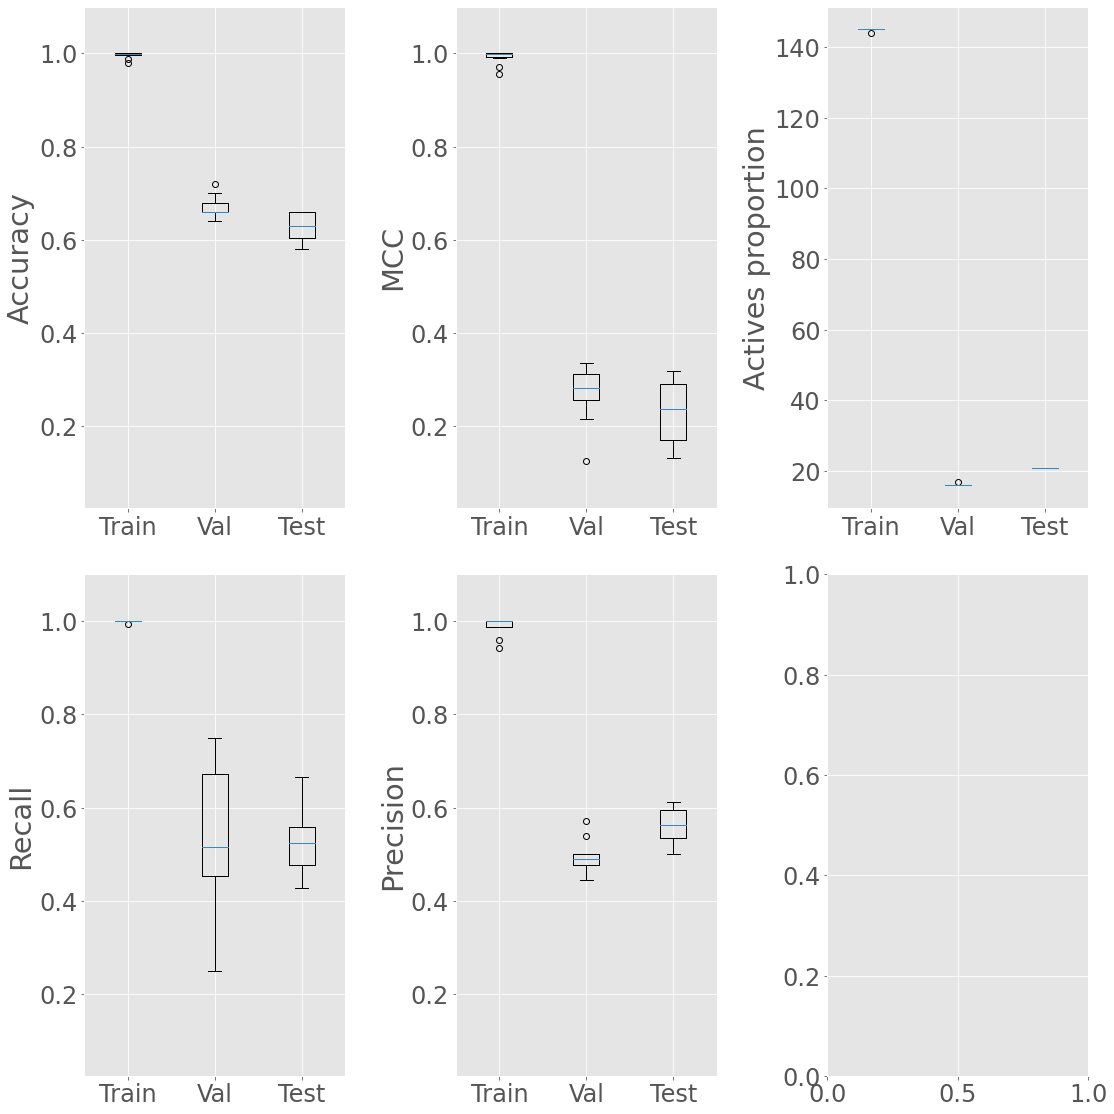

In [33]:
plot_results_CV(*CV_parameters)

### 7.2.) Tunning Hyperparameters

In [17]:
hyperparam_tunning = False

HP_HIDDEN_LAYERS = hp.HParam("hidden_layers", hp.Discrete(list(range(3, 10))))
HP_NEURONS = hp.HParam("neurons", hp.Discrete([i for i in range(10,151,20)]))
HP_DROPOUT = hp.HParam("dropout", hp.RealInterval(0.2, 0.5))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd','RMSprop']))
HP_L2 = hp.HParam('l2 regularizer', hp.RealInterval(.001,.01))
HP_LR = hp.HParam("learning_rate", hp.Discrete([0.001, 0.01, 0.1, 1.0, 10.0]))
N_BITS = train_data.shape[1]
    
def construct_optimizer(hparams):
    if hparams[HP_OPTIMIZER] == "adam":
        return tf.keras.optimizers.Adam(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "sgd":
        return tf.keras.optimizers.SGD(learning_rate = hparams[HP_LR])
    elif hparams[HP_OPTIMIZER] == "RMSprop":
        return tf.keras.optimizers.RMSprop(learning_rate = hparams[HP_LR])
    
def train_test_model(hparams):
    internal_layers = [tf.keras.layers.Dropout(hparams[HP_DROPOUT])]+[tf.keras.layers.Dense(hparams[HP_NEURONS], kernel_regularizer=tf.keras.regularizers.l2(hparams[HP_L2]), activation='relu') for _ in range(hparams[HP_HIDDEN_LAYERS])]
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(N_BITS, activation='relu', input_shape=(N_BITS,))]+
        internal_layers+[tf.keras.layers.Dense(1, activation="sigmoid")]
    )
    model.compile(optimizer=construct_optimizer(hparams), loss="binary_crossentropy", metrics=['accuracy'])
    model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)
    _, results = model.evaluate(val_data, val_labels, verbose=0)                                                                                                
    _, results_val = model.evaluate(mini_testing_2c9_data, mini_labels_testing_2c9_data, verbose=0)
    return results, results_val 


def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy, accuracy_val = train_test_model(hparams)
    tf.summary.scalar("accuracy", accuracy, step=1)
    tf.summary.scalar("accuracy_val", accuracy_val, step=1)

In [18]:
os.makedirs("hyperparameters_tunning/morgan_feature_selection", exist_ok=True)
with tf.summary.create_file_writer('hyperparameters_tunning/morgan_feature_selection').as_default():
    hp.hparams_config(hparams=[HP_HIDDEN_LAYERS,HP_NEURONS, HP_DROPOUT, HP_OPTIMIZER, HP_L2, HP_LR],
                      metrics=[hp.Metric("accuracy", display_name='Accuracy'), hp.Metric("accuracy_val", display_name="Validation_accuracy")]) 

In [21]:
%tensorboard --logdir hyperparameters_tunning/morgan_feature_selection/logs/hparam_tuning/

In [20]:
if hyperparam_tunning:
    session_num = 0
    looping = list(product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values,[HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values))
    random.shuffle(looping)
    #looping = product(HP_NEURONS.domain.values, HP_HIDDEN_LAYERS.domain.values, [HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value], HP_OPTIMIZER.domain.values, [HP_L2.domain.min_value, HP_L2.domain.max_value], HP_LR.domain.values)
    total_runs = len(list(looping))
    for neurons, hidden_lay, dropout, opt, l2, lr in looping:
        hp_params = {HP_NEURONS: neurons, HP_HIDDEN_LAYERS: hidden_lay, HP_DROPOUT: dropout, HP_OPTIMIZER: opt, HP_L2: l2, HP_LR: lr}
        if session_num % 10 == 0:
            # clear everything every 10 models to avoid oom errors
            tf.keras.backend.clear_session()
        run_name = f"run_{session_num}"
        print(f"---Starting trial: {run_name} of {total_runs}")
        print({h.name: hp_params[h] for h in hp_params})
        run('hyperparameters_tunning/morgan_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
        session_num += 1

---Starting trial: run_0 of 3360
{'neurons': 10, 'hidden_layers': 4, 'dropout': 0.2, 'optimizer': 'adam', 'l2 regularizer': 0.01, 'learning_rate': 0.1}
Train on 375 samples
Epoch 1/10
375/375 - 5s - loss: 1.0549 - accuracy: 0.4320
Epoch 2/10
375/375 - 0s - loss: 0.9410 - accuracy: 0.6773
Epoch 3/10
375/375 - 0s - loss: 0.8488 - accuracy: 0.3387
Epoch 4/10
375/375 - 0s - loss: 0.7474 - accuracy: 0.3227
Epoch 5/10
375/375 - 0s - loss: 0.7195 - accuracy: 0.3227
Epoch 6/10
375/375 - 0s - loss: 0.7066 - accuracy: 0.6507
Epoch 7/10
375/375 - 0s - loss: 0.7004 - accuracy: 0.6160
Epoch 8/10
375/375 - 0s - loss: 0.6978 - accuracy: 0.5227
Epoch 9/10
375/375 - 0s - loss: 0.6965 - accuracy: 0.4240
Epoch 10/10
375/375 - 0s - loss: 0.6950 - accuracy: 0.4480
---Starting trial: run_1 of 3360
{'neurons': 150, 'hidden_layers': 7, 'dropout': 0.2, 'optimizer': 'RMSprop', 'l2 regularizer': 0.001, 'learning_rate': 0.01}
Train on 375 samples
Epoch 1/10
375/375 - 8s - loss: 5.3014 - accuracy: 0.5760
Epoch 2/1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-baae3946508b>", line 15, in <module>
    run('hyperparameters_tunning/morgan_feature_selection/logs/hparam_tuning/' + run_name, hp_params)
  File "<ipython-input-17-6033f3c41ffa>", line 35, in run
    accuracy, accuracy_val = train_test_model(hparams)
  File "<ipython-input-17-6033f3c41ffa>", line 26, in train_test_model
    model.fit(train_data, train_labels, epochs=10, verbose=2, class_weight=class_weight)
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "/Users/Anna/miniconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "/Users/Anna/miniconda3/


KeyboardInterrupt

